## Problem statement:
- Predict the price of diamonds given diamonds typical's attributes (carat, cut, color, etc)
- Dataset taken from https://www.kaggle.com/shivam2503/diamonds, consisting of:
    - 53940 rows and 10 features

## Project Pipeline:
- Collect data
- EDA
- Model selection and hyperparameter turning (GridSearch CV)
    - Start with Linear Regression
    - Compare other regressors' performance: Ridge, Lasso, SVR, Decision Tree, Random Forest and XGBoost
- Run best models on unseen data

In [253]:
# pip install xgboost

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
### Supervised ML techniques to be compared
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import RANSACRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor 

### Evaluate the different models
from sklearn.metrics import r2_score

In [79]:
df = pd.read_csv("diamonds.csv")
# https://www.kaggle.com/shivam2503/diamonds

In [80]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [300]:
df.shape

(53940, 10)

## Exploratory Data Analysis

### Cleanliness of data:
- Null values / Nan
- Uniqueness: unique combination of attributes in the dataset

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [82]:
#### Since there is no unqiue ID, finding unique values by summing all unique combinations
print("Number of repeated items: {:d}".format((df.groupby(list(df.columns)).size()>1).sum()))

Number of repeated items: 143


In [83]:
#### Remove all repeated items
df.drop_duplicates(subset =list(df.columns),keep="first")

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


### Types of data and ordinal mapping: 
Ordinal / nominal // categorical / continuous data :
- Carat, depth, table, x,y,z are ordinal continuous data
- Cut can be encoded as ordinal categorical data
- Color and Clarity can be ranked in terms of grades and used as ordinal categorical data

In [84]:
df.nunique()

carat        273
cut            5
color          7
clarity        8
depth        184
table        127
price      11602
x            554
y            552
z            375
dtype: int64

In [85]:
for i in ["cut","color","clarity"]:
    print(df[i].value_counts())

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64
SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64


In [86]:
#### Mapping ordinal categorical data to ordinal continuous data
#### Reference from https://www.bluenile.com/education/diamonds
cut_map = {"Fair":1,"Good":2,"Very Good":3,"Premium":4,"Ideal":5}
clarity_map ={"I1":1,"SI2":2,"SI1":3,"VS2":4,"VS1":5,"VVS2":6,"VVS1":7,"IF":8}  #### increasing clarity
color_map = {"J":1,"I":2,"H":3,"G":4,"F":5,"E":6,"D":7} #### increaing clearness

df["color"] = df["color"].map(color_map)
df["cut"] = df["cut"].map(cut_map)
df["clarity"] = df["clarity"].map(clarity_map)

### Distribution of data

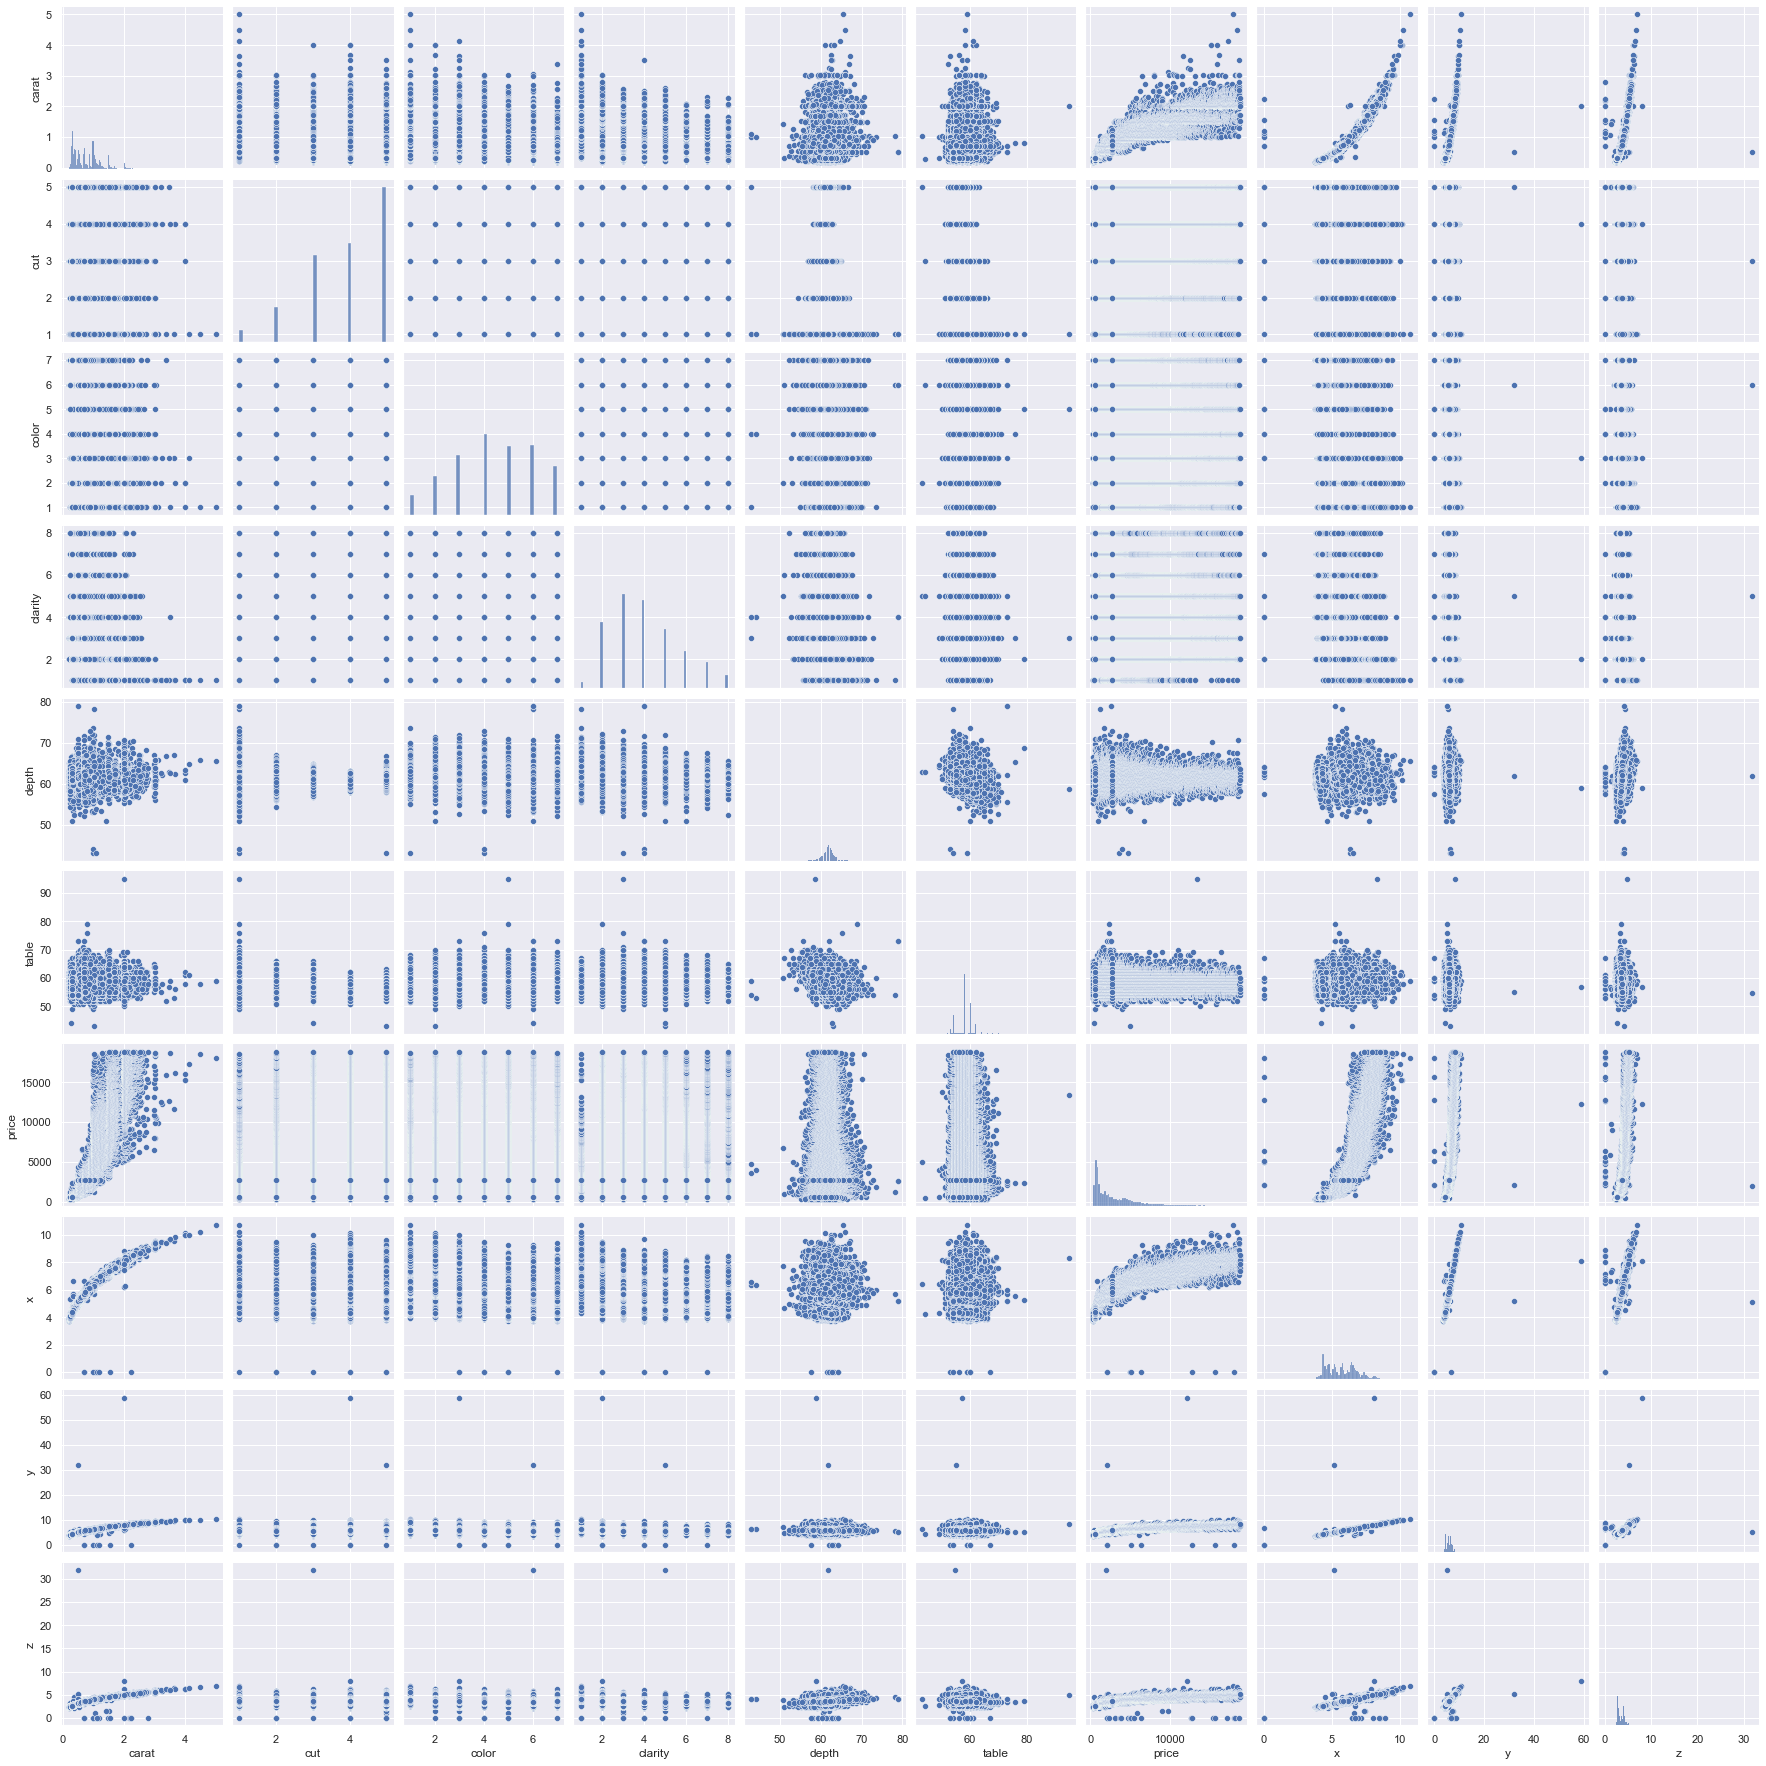

In [87]:
sns.pairplot(df,height = 2.5)

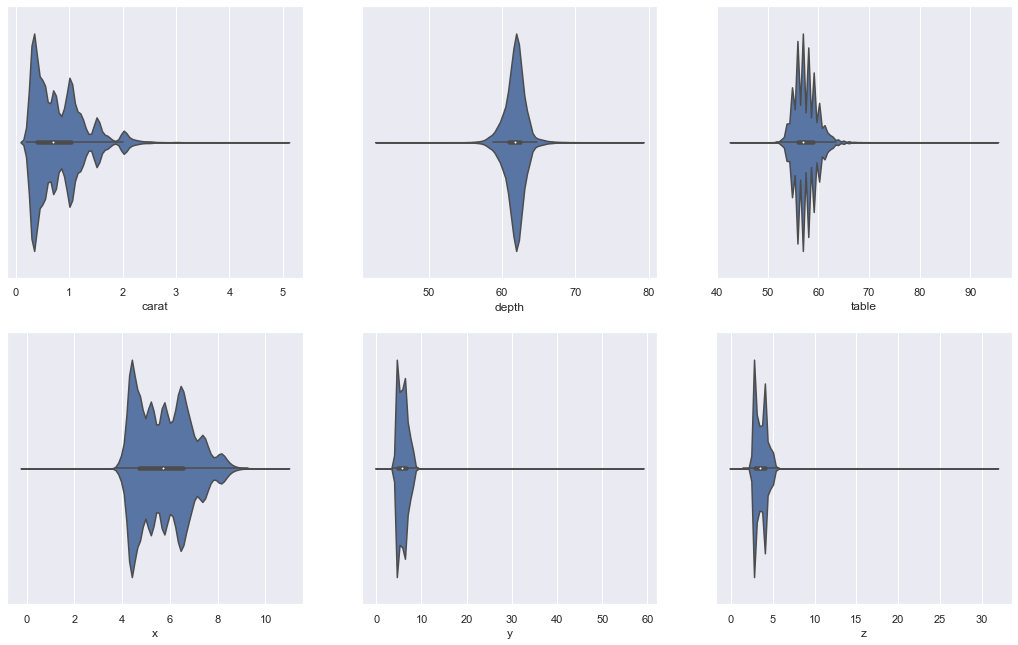

In [115]:
sns.set(rc = {'figure.figsize':(18,11)})
cols = ["carat","depth","table","x","y","z"]
fig, ax = plt.subplots(2,3)
i = 0
while i < 3:
    sns.violinplot(ax=ax[0,i],x=df[cols[i]])
    sns.violinplot(ax=ax[1,i],x=df[cols[i+3]])
    i += 1
# sns.violinplot(x=df["price"],orient="v")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of prices')

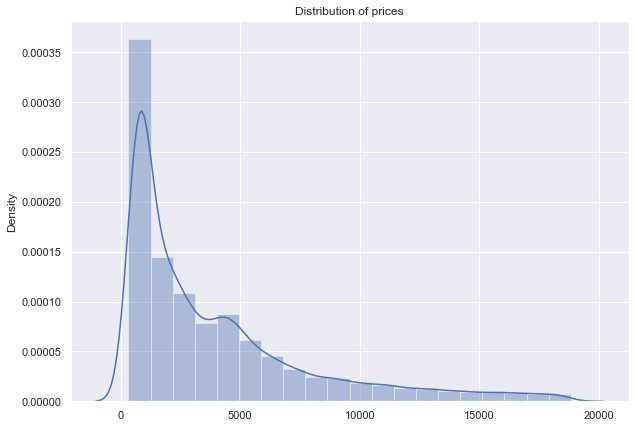

In [118]:
sns.set(rc = {'figure.figsize':(10,7)})
sns.distplot(x=df["price"],bins=20)
plt.title("Distribution of prices")

The dataset consists of:
- Mainly low carat diamonds, corresponding to lower value prices
- Normally distributed depth
- some outliers in y and z dimensions

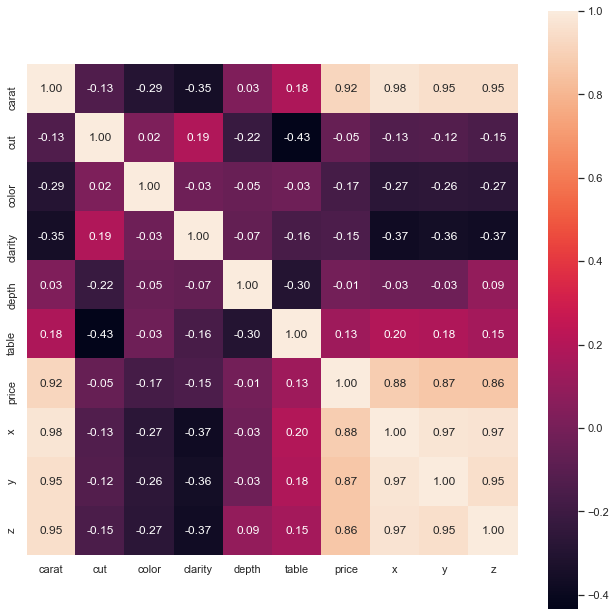

In [90]:
### Determine correlation amongst attributes - measuring linear dependce between pairs of features
cols = [i for i in df.columns if i !="price"]
cm = np.corrcoef(df.values.T)
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt=".2f",yticklabels=df.columns,xticklabels=df.columns)
sns.set(rc = {'figure.figsize':(11,11)})

Note: the dimensions, x,y,z and carat have a strong positive linear relationship, i.e. Collinear features, <br>
Price has a strong linear correlation with carat, x,y,z

## Model selection: first trial with LinearRegression

### Train test data split
- Since there is no clear linear relationship between other atributes (other than carat) with prices, the train and test datasets need to contained sufficiently varied occurrances of these attributes

In [128]:
x = df[["carat","cut","clarity","color","table","depth"]]
y = df["price"]

In [139]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=101)
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
# sss.get_n_splits(x, y)
# # print(sss)
# for train_index, test_index in sss.split(x, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     x_train, x_test = x[train_index], x[test_index]
#     y_train, y_test = y[train_index], y[test_index]

#### Machine learning algorithm definition:
- Scale the feature space using standard scaler - easier to compare the relevance of features
- Implementing regression algorithm: use LinearRegression as a start

In [185]:
#### Rescale Features 
scaler = StandardScaler()
lr = LinearRegression()

pipe = Pipeline([("scaler", scaler),
                 ("linear_regression", lr)])

In [204]:
cv= RepeatedKFold(n_splits=5,n_repeats=3,random_state=675204)
print("Accuracy on test sets in validation process")
cross_val_score(pipe, x_train, y_train, cv=cv)  #### no trained model returned, only scores are returned

Accuracy on test sets in validation process


array([0.89896748, 0.91240845, 0.9016496 , 0.90399707, 0.9042353 ,
       0.90560943, 0.90021347, 0.90696397, 0.9016251 , 0.90716633,
       0.90430717, 0.90208416, 0.90903243, 0.90349491, 0.9024153 ])

In [179]:
scores = cross_validate(pipe, x_train, y_train, cv=cv, scoring='r2', return_train_score=True,
                       return_estimator=True, n_jobs=-1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [199]:
print("Attributes returned as part of scores: \n %s" % scores.keys())
print("R2-score from train set: \n %s" % scores["train_score"])  # Will print your training score
print("R2-score from test set: \n %s" % scores["test_score"])  # Will print test score
print("R2_train - R2_test: \n %s" % list(scores["train_score"]-scores["test_score"]))

Attributes returned as part of scores: 
 dict_keys(['fit_time', 'score_time', 'estimator', 'test_score', 'train_score'])
R2-score from train set: 
 [0.90390416 0.90455797 0.90556832 0.90401628 0.90366888 0.90402134
 0.90517786 0.90495594 0.90467074 0.90291272 0.90388902 0.90497311
 0.90411836 0.9055032  0.90324011]
R2-score from test set: 
 [0.90599944 0.90343759 0.89929358 0.90551501 0.90706609 0.90551066
 0.90087282 0.90180238 0.90297073 0.91020041 0.90605062 0.90174766
 0.90523015 0.89975431 0.90883921]
R2_train - R2_test: 
 [-0.002095289101336162, 0.0011203777687940342, 0.006274745237296653, -0.0014987331506939316, -0.003397213193124582, -0.0014893193065057542, 0.00430503158603579, 0.0031535565161813217, 0.0017000095512772484, -0.007287690363971144, -0.0021616016580018327, 0.003225452301024445, -0.001111797396714409, 0.005748889909591548, -0.005599095672633392]


Overfitting means the accuracy in training train set is higher than test set. From this analysis, LR did not overfit the training data

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Coefficient importance and its variability')

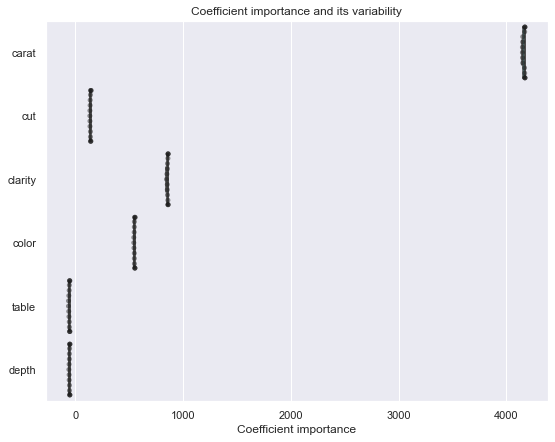

In [181]:
coefs = pd.DataFrame(
    [est.named_steps['linear_regression'].coef_ for est in scores['estimator']],
    columns=x_train.columns)

plt.figure(figsize=(9, 7))
sns.swarmplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
# plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')

Variance of coefficience across the different validation runs is not substantial

## Model Selection: Finding the best set of parameters using gridsearchCV

#### Defining algorithsm to be tested and their hyperparameter range

In [221]:
np.linspace(3,11,2)

array([ 3., 11.])

In [260]:
pipe = pipe = Pipeline([("scaler", scaler),
                 ("regressor", lr)])
cv= RepeatedKFold(n_splits=5,n_repeats=3,random_state=675204)
########################################################################################
param_list_regu = [{"regressor":[Ridge(),Lasso()],   ##### Reduce overfitting
              "regressor__alpha":np.geomspace(1e-5,1e2,10)}]  ### alpha = 2lamda, larger alpha = more regularisation. Type of solver and max_iter can be changed id not converged
param_list_ransac = [{"regressor":[RANSACRegressor(LinearRegression(),max_trials=100,min_samples=50,loss="absolute_loss",random_state=0)],
                     "regressor__residual_threshold":[None,10]}]
param_list_tree = [{"regressor": [DecisionTreeRegressor(criterion="mse")],  ### criterion can be adju
              "regressor__max_depth":range(3,11,2)}]
param_list_rf = [{"regressor": [RandomForestRegressor(criterion ='mse',random_state=1)],
              "regressor__n_estimators":[10,100,1000], #### number of trees in the forest
              "regressor__max_depth":[5,10]}]
param_list_xgb = [{"regressor": [XGBRegressor()],
              "regressor__n_estimators":[10,100],
              "regressor__max_depth":[5,10],
#               "regressor__eta":[0.1,0.01],
              "regressor__subsample":[1,0.5]}]
param_list_svr =[{"regressor":[SVR()],
              "regressor__kernel":["linear","poly","rbf"],
              "regressor__degree":[2,3,4]}]  #### degree of polynomial kernel used in SVM


param_list_all = [param_list_regu,param_list_ransac,param_list_tree,param_list_rf,
                 param_list_xgb,param_list_svr]  
param_name =["Regularisation","RANSAC","Decision tree","Random Forest","XGBoost","SVR"]

#### For each algorithm, finding the best combination of hyperparameter as a result of gridsearchCV

In [261]:
%%time
grid_result=[]
for plist,name in zip(param_list_all,param_name):
    tick = time.time()
    gscv = GridSearchCV(pipe,param_grid=plist,scoring="r2",cv=cv,verbose=1,return_train_score=True,n_jobs=-1)
    gscv.fit(x_train,y_train)
    print("Time taken for {:s}: {:.3f}s".format(name,(time.time()-tick)))
    grid_result.append(gscv)

Fitting 15 folds for each of 20 candidates, totalling 300 fits
Time taken for Regularisation: 5.316s
Fitting 15 folds for each of 2 candidates, totalling 30 fits
Time taken for RANSAC: 1.326s
Fitting 15 folds for each of 4 candidates, totalling 60 fits
Time taken for Decision tree: 0.971s
Fitting 15 folds for each of 6 candidates, totalling 90 fits
Time taken for Random Forest: 270.265s
Fitting 15 folds for each of 8 candidates, totalling 120 fits
Time taken for XGBoost: 49.953s
Fitting 15 folds for each of 9 candidates, totalling 135 fits
Time taken for SVR: 5595.858s
Wall time: 1h 38min 43s


#### Comparing the best result from each ML algorithm

In [281]:
# %%time
train_score_list = []
test_score_list = []
best_list=[]
for grid,name in zip(grid_result,param_name):
    tick = time.time()
    best_estimator = grid.best_estimator_
    best_list.append(best_estimator)
    cv_results = cross_validate(best_estimator, x_train, y_train, cv=cv, scoring='r2', return_train_score=True,
                       return_estimator=True, n_jobs=-1)
    
    train_score = cv_results["train_score"]
    test_score = cv_results["test_score"]
    train_score_list.append(train_score)
    test_score_list.append(test_score)
    
    runtime = time.time()-tick
    #### Print out message to measure 
    msg = "Estimator: {:15s} Mean of train_cv: {:.3f} +/- {:.3f} Mean of test_cv:{:.3f} +/- {:.3f} Run time: {:.2f}s".format(
        name, train_score.mean(), train_score.std(),test_score.mean(), test_score.std(),runtime)
    print(msg)

Estimator: Regularisation  Mean of train_cv: 0.904 +/- 0.001 Mean of test_cv:0.904 +/- 0.003 Run time: 3.12s
Estimator: RANSAC          Mean of train_cv: 0.886 +/- 0.005 Mean of test_cv:0.886 +/- 0.005 Run time: 0.74s
Estimator: Decision tree   Mean of train_cv: 0.979 +/- 0.000 Mean of test_cv:0.973 +/- 0.001 Run time: 0.38s
Estimator: Random Forest   Mean of train_cv: 0.986 +/- 0.000 Mean of test_cv:0.980 +/- 0.001 Run time: 139.87s
Estimator: XGBoost         Mean of train_cv: 0.988 +/- 0.000 Mean of test_cv:0.981 +/- 0.001 Run time: 6.82s
Estimator: SVR             Mean of train_cv: 0.856 +/- 0.001 Mean of test_cv:0.856 +/- 0.003 Run time: 397.47s


###### Observation: 
- Comparison between the mean r2 of training sets and testing sets in cross validation run reveals that none of the best results from the various algorithsm overfit the training data as there is no significant reduction in testing r2 means compared to training r2 means
- XGBoost is superior to the rest of the algorithsm being close to 10x faster than random forest without reducing accuracy
- The worst algorithsm is SVR with the lowest r2 value and longest model run
- The small variance of r2 values from different folds in the cross-validation runs -> no random fold result skew the accuracy

In [288]:
##### UNpacking cv_results_ where many useful information pieces are stored after GridSearchCV
# grid_result[0].cv_results_

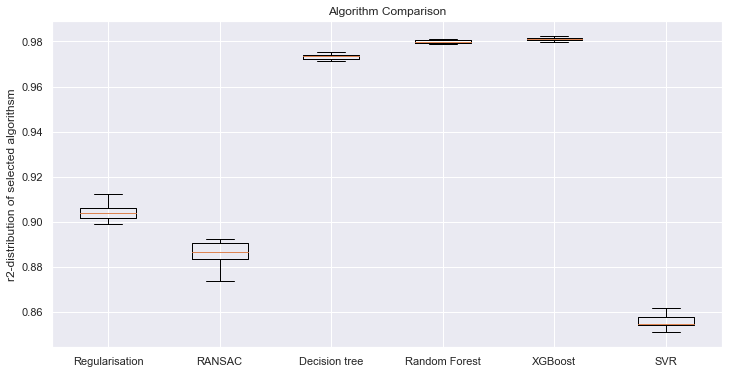

In [287]:
# boxplot algorithm comparison
fig,ax = plt.subplots(figsize=(12,6))
ax.set_title('Algorithm Comparison')
plt.boxplot(test_score_list)
ax.set_xticklabels(param_name)
ax.set_ylabel("r2-distribution of selected algorithsm")
plt.show()

###### Take decision tree, random forest and XGboost - higest r2 - to test on unseen data

## Running the best models on unseen test data

In [299]:
for best,name in zip(best_list[2:5],param_name[2:5]):
    best_score = best.score(x_test,y_test)
    print("Algorithm {:15s} with test score on unseen data: {:.3f}".format(name,best_score))

Algorithm Decision tree   with test score on unseen data: 0.974
Algorithm Random Forest   with test score on unseen data: 0.980
Algorithm XGBoost         with test score on unseen data: 0.982
